# Introduction
The following examples show how to use the **grand** library to monitor systems (units) that generate data over time. The library allows to detect anomalies/deviations in a streaming fashion, and has models for both *individual* and *group* anomaly detection.

In *individual* anomaly detection, a system is compared against a fixed reference dataset ([section 1](#section1)), or against its own past historical data ([section 2](#section2)). In *group* anomaly detection, each target system is compared against a group of other similar systems ([section 3](#section3)).

- [Section 1: Stationary streaming data](#section1)
- [Section 2: Non-stationary streaming data with seasonality / periodicity](#section2)
- [Section 3: Group-based anomaly detection in non-stationary streaming data](#section3)

In [1]:
# NOTE: run this cell before anything else
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from grand import IndividualAnomalyInductive, IndividualAnomalyTransductive, GroupAnomaly
from grand.datasets import load_artificial

import grand
print(grand.__version__)

0.2


<a id='section1'></a>
# 1. Stationary streaming data
Let's start with the simplest senario: a stationary data stream. The observations in a stationary data stream are not dependent on time; they are sampled iid from an unknown underlying distribution. The following is an example of an artificial multivariate time-series (two-features) which do not have trend or seasonal effects.

            Feature 0  Feature 1
Date                            
1959-01-01         35  20.835502
1959-01-02         32  19.059137
1959-01-03         30  21.119310
1959-01-04         31  12.945256
1959-01-05         44  29.281085


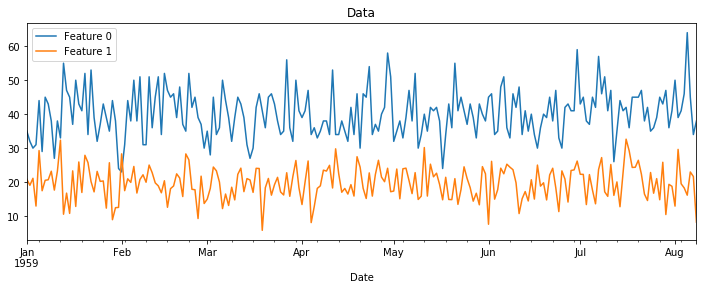

In [2]:
df0 = pd.read_csv('data/stationary-0.csv', header=0, index_col=0, parse_dates=True)
print(df0.head(5))

df0.plot(figsize=(12, 4), title="Data")
plt.show()

To look for anomalies in such a stationary data stream, we can create an anomaly detection model using the `IndividualAnomalyInductive` class. We fit the model to a fixed reference dataset `X_fit` which is assumed to be normal (i.e. without anomalies). For example, `X_fit` can be the first $n$ samples from the stream.

For each new data-point $x_t$ received at time $t$, the model computes a non-conformity (or strangeness) measure $S_{x_t}$. This measure is specified by the parameter `non_conformity`. If it is set to `"median"`, then the distance from $x$ to the median of `X_fit` is used. If it is set to `"knn"`, then the average distance from $x$ to its $k$ nearest neighbours in `X_fit` is used. Other non-conformity measures will also be included in later versions.

A p-value $p_t$ is also computed at time $t$ as follows:
$$
p_t = \frac{\#\{x_i \in \text{X_fit} \mid S_{x_i} > S_{x_t}\}}{n} \in [0, 1]
$$

Finally, a deviation level $M_t$ is computed based on the last $w$ p-values $\{p_{t-w}, \dots, p_t \}$, as follows:
$$
M_t = \frac{1}{2 w} \sum_{i = t-w}^{t} \left ( -p_i + \frac{1}{2} \right ),
$$
where $w$ is referred to as `w_martingale` is the code. This deviation level $M_t$ measures how uniform the p-values are over time. If the new data-points comes from the same distribution as `X_fit`, then the p-values will be uniformly distributed in $[0, 1]$ and the deviation level will be low (close to 0).

The usage of the `IndividualAnomalyInductive` model is illustrated in the following code. After running the code, you will see that the deviation level is always low (close to 0) as long as the data continues to come from the same distribution as `X_fit`.

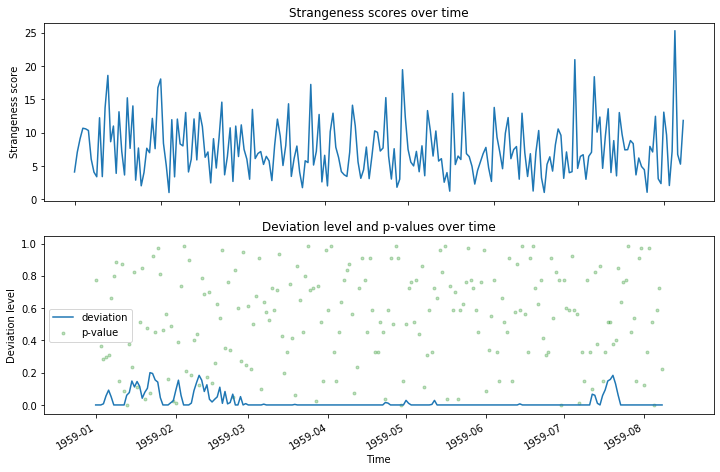

In [3]:
# Create a model using IndividualAnomalyInductive
model = IndividualAnomalyInductive(
            w_martingale = 15,          # Window size for computing the deviation level
            non_conformity = "median",  # Strangeness measure: "median" or "knn"
            k = 20                      # Used if non_conformity is "knn"
)


# Fit the model to a fixed subset of the data
X_fit = df0.head(n = 80).values
model.fit(X_fit)


# At each time step t, a data-point x comes from the stream
for t, x in zip(df0.index, df0.values):
    info = model.predict(t, x)
    print("Time: {} ==> strangeness: {}, deviation: {}" .format(t, info.strangeness, info.deviation), end="\r", flush=True)

# Plot strangeness and deviation level over time
model.plot_deviations(figsize=(12, 8))

## 1.1. Deviation due to a change in the data distribution
In the following dataset `stationary-1.csv`, a period of time (after August) is added where the data start to slowly deviate and come from a different distribution than `X_fit`. After running the following code, you will notice that the deviation level increased significantly (indicating an anomaly) during the period where the change in the data distribution happened.

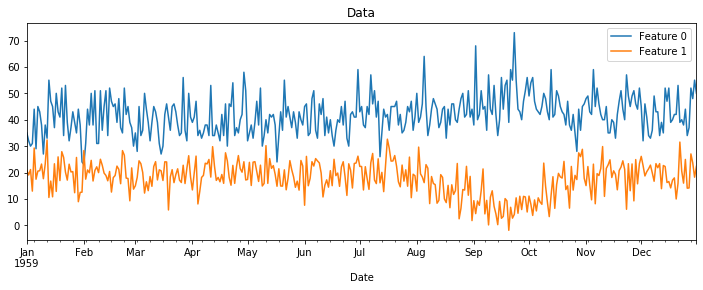

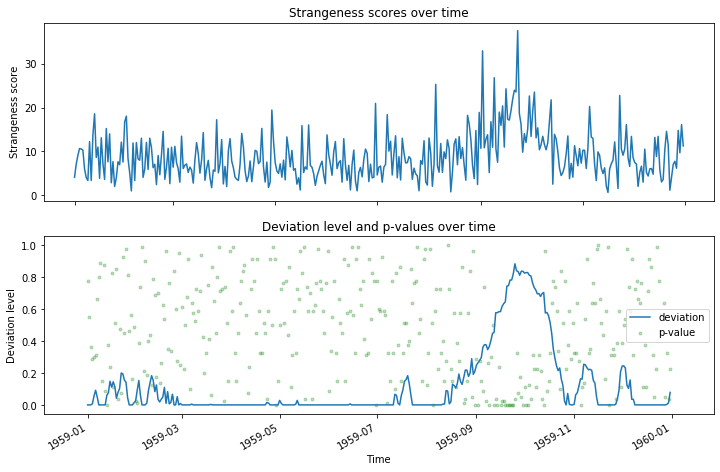

In [4]:
df1 = pd.read_csv('data/stationary-1.csv', header=0, index_col=0, parse_dates=True)
df1.plot(figsize=(12, 4), title="Data")
plt.show()

model = IndividualAnomalyInductive(w_martingale = 15, non_conformity = "median", k = 20)
model.fit(X_fit)

for t, x in zip(df1.index, df1.values):
    info = model.predict(t, x)
    print("Time: {} ==> strangeness: {}, deviation: {}" .format(t, info.strangeness, info.deviation), end="\r", flush=True)

model.plot_deviations(figsize=(12, 8))

## 1.2. The effect of outliers on the deviation level
The following dataset `stationary-2.csv` shows the same data as the previous one, but with few outliers arround mid April. After running the following code, you will notice that such few outliers do not affect the deviation level as it is computed based on several consecutive samples from the stream. These outliers are however captured by the strangeness score, which is computed on individual samples from the stream.

The "strangeness score" reflects the non-conformity (strangeness) of individual samples, while the "deviation level" reflects collective anomalies or a consistent change in the data distribution over time.

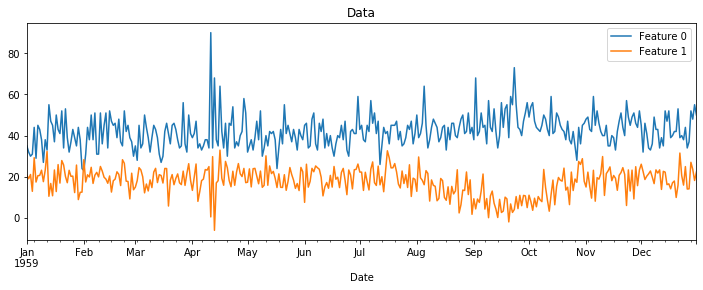

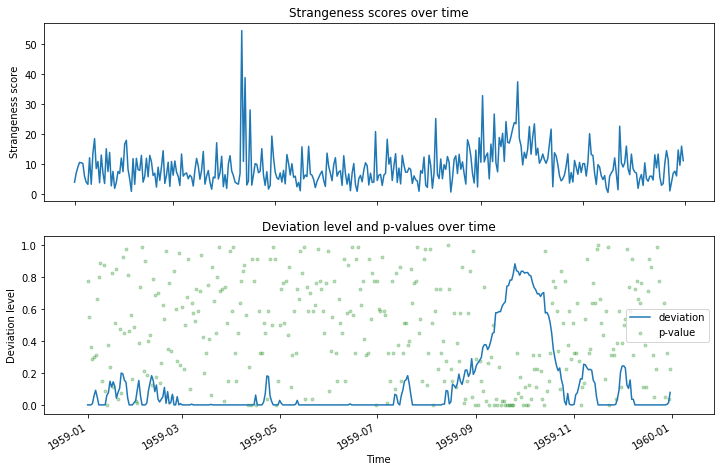

In [5]:
df2 = pd.read_csv('data/stationary-2.csv', header=0, index_col=0, parse_dates=True)
df2.plot(figsize=(12, 4), title="Data")
plt.show()

model = IndividualAnomalyInductive(w_martingale = 15, non_conformity = "median", k = 50)
model.fit(X_fit)

for t, x in zip(df2.index, df2.values):
    info = model.predict(t, x)
    print("Time: {} ==> strangeness: {}, deviation: {}" .format(t, info.strangeness, info.deviation), end="\r", flush=True)

model.plot_deviations(figsize=(12, 8))

<a id='section2'></a>
# 2. Non-stationary streaming data with seasonality / periodicity
Observations from a non-stationary time series show seasonal effects, trends, and other structures that depend on the time.

## Taxi passengers example
The following dataset `nyc_taxi.csv` consists of a univariate time series representing the number of NYC taxi passengers aggregated into 30 minute buckets (for 7 months of data). The plot below shows a subset of the data corresponding to the first two weeks of July (starting on Tuesday).

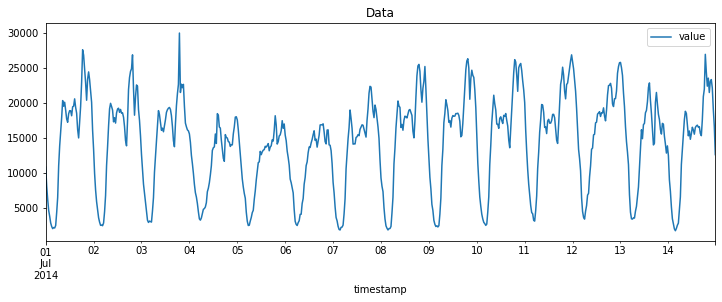

In [6]:
df = pd.read_csv('data/nyc_taxi.csv', header=0, index_col=0, parse_dates=True)

df.head(336*2).plot(figsize=(12, 4), title="Data")
plt.show()

This non-stationary dataset is however periodic as we see similar patterns repeating over days and weeks.

One way to look for anomalies in such data stream is to create an anomaly detection model using the class `IndividualAnomalyTransductive`. This model takes a parameter `ref_group` specifying the criteria to use in orde to construct a reference dataset. Each time the `predict` function is called for a new sample `x` at time `t`, a reference dataset is constructed from historical data (prior to `t`) based on the criteria specified in `ref_group`.

The parameter `ref_group` takes one or more criteria from the following: `["hour-of-day", "day-of-week", "day-of-month", "week-of-year", "month-of-year", "season-of-year"]`. It can also be set to `ref_group = "external"` if we want to specify our own criteria which doesn't necessarily depend on time.

In the code below, we have set `ref_group = ["hour-of-day", "day-of-week"]` for the Taxi dataset. This means that each new sample `x`, received at current time `t`, will be compared against historical samples where the *hour-of-the-day* was the same as the current hour and the *day-of-the-week* was the same as the current weekday.

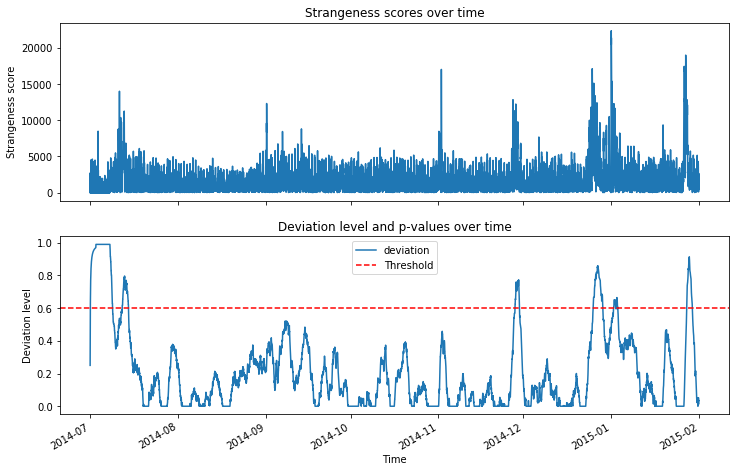

In [7]:
# Create a model using IndividualAnomalyTransductive
model = IndividualAnomalyTransductive(
            w_martingale = 100,         # Window size for computing the deviation level
            non_conformity = "median",  # Strangeness measure: "median" or "knn"
            k = 20,                     # Used if non_conformity is "knn"
            ref_group = ["hour-of-day", "day-of-week"]  # Criteria for reference group construction
)


# At each time step t, a data-point x comes from the stream
for t, x in zip(df.index, df.values):
    info = model.predict(t, x)
    print("Time: {} ==> strangeness: {}, deviation: {}".format(t, info.strangeness, info.deviation), end="\r")


# Plot strangeness and deviation level over time
model.plot_deviations(figsize=(12, 8))

The following code highlights periods where some events occured (e.g. the NYC marathon, Thanksgiving, Christmas, New Year days, and a snow storm) that lead to a high anomaly score.

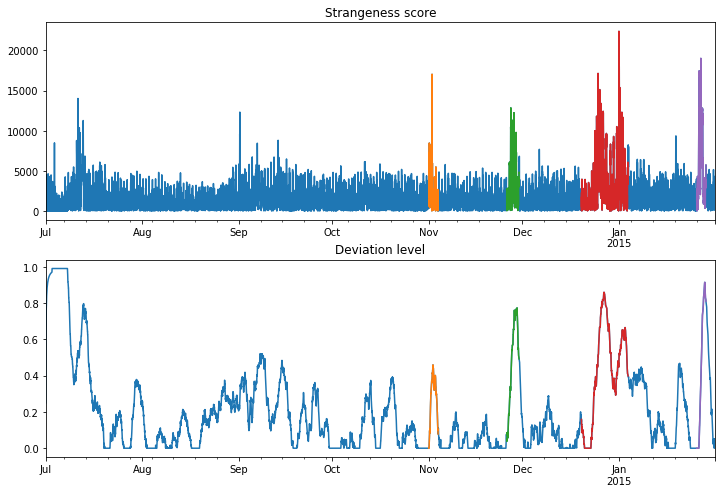

In [8]:
periods = [
    ("2014-11-01", "2014-11-03"),  # NY city Marathon on 2014-11-02
    ("2014-11-26", "2014-11-29"),  # Thanksgiving on 2014-11-27
    ("2014-12-20", "2015-01-03"),  # Christmas and new year days
    ("2015-01-26", "2015-01-28")   # Bad weather (snow storm)
]

stats = model.get_stats()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
stats["strangeness"].plot(ax=ax1, title="Strangeness score")
stats["deviation"].plot(ax=ax2, title="Deviation level")
for frm, to in periods:
    stats[frm:to]["strangeness"].plot(ax=ax1)
    stats[frm:to]["deviation"].plot(ax=ax2)

plt.show()

The class `IndividualAnomalyTransductive` assumes that there is some kind of periodicity and that there is sufficient historical data to construct a reference dataset for each new sample. However, it becomes not possible to use such model when:
- The external conditions that affects the distribution of the data are unknown.
- Or, when there is no sufficient amount of historical data (e.g. seasonality happens over years).
- Or, when there is no periodicity in the non-stationary data stream at all.

<a id='section3'></a>
# 3. Group-based anomaly detection in non-stationary streaming data

To detect anomalies in a given system, it is necessary to define what a *normal system behavior* is. With the `IndividualAnomalyInductive` detector, the data was assumed to be sampled from a stationary distribution, and the model was fitted to a fixed dataset representing the *normal system behavior*. With the `IndividualAnomalyTransductive` detector, some form of a *normal system behavior* was also required. For example: some knowledge about the periodicity of the data, or the external factors affecting the data distribution over time.

In this section we see how to use the `GroupAnomaly` detector, which is usefull when the definition of what is normal is not fixed and the above-mentioned knowledge is not available.

In the `GroupAnomaly` model, a group of several systems generate data over time (i.e. multiple non-stationary data streams). These systems are assumed to be subject to the same external conditions that influences their data distributions. An anomaly is detected when the data from a target system starts to change differently from the other systems.

The parameters of `GroupAnomaly` and their default values are as follows:

```python
model = GroupAnomaly(
    nb_units,                   # Number of units (i.e. systems)
    ids_target_units,           # Ids of the (target) units to diagnoise
    w_ref_group = "7days",      # Time window for the reference group
    w_martingale = 15,          # Window size for computing the deviation level
    non_conformity = "median",  # Strangeness measure: "median" or "knn"
    k = 20,                     # Used if non_conformity is "knn"
    transformer = "pvalue",     # Transform each unit's data separately to make them more comparable
    w_transform = 30)           # Window size used when transformer is set to "mean_pvalue"
```

At each time step $t$, a list of data-points `x_units` is received. Each data-point `x_units[i]` corresponds to the $i^{th}$ system. The length of `x_units` should correspond to `nb_units` (i.e. `len(x_units) == nb_units`). A data-point $x_t^{(i)}$ at time $t$ from the $i^{(th)}$ target system, is compared against a reference dataset constructed from the data of the other systems during the past `w_ref_group` time period. The `predict` method is called as `infos = model.predict(t, x_units)` and returns a list of information. Each element in `info` contains information related to one target system (whose id was specified in `ids_target_units`).

```python
for t, x_units in dataset.stream():
    infos = model.predict(t, x_units)
```

To illustrate how the `GroupAnomaly` model works, we will use some built-in artificial datasets and use the default parameters shown above. These artificial datasets consist of univariate time-series from several systems. However, the code works also well on more general multivariate time-series.

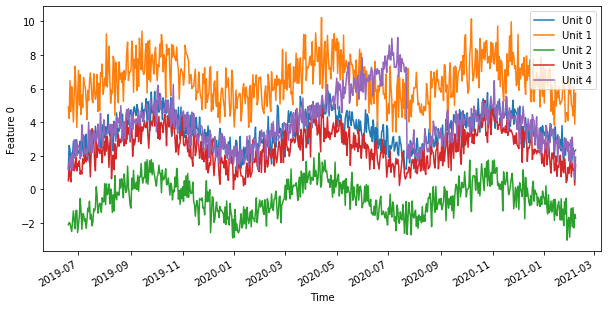

In [9]:
dataset_id = 0                             # You can try 0, 1, 2, 3, 4, 5 ... to load other datasets
dataset = load_artificial(dataset_id)      # Load artificial dataset number 0

nb_units = dataset.get_nb_units()          # Number of systems (data-streams)
ids_target_units = list(range(nb_units))   # Ids of the systems to diagnoise (here all)

dataset.plot( figsize=(10, 5) )

As you see from the above figure, the last system (Unit 4) simulates an anomaly during some period of time. The 5 data-streams from the different systems (Unit 0 to 4) change similarly over time, but have different locations. One way to make them comparable is to normalize the data from each system on-the-fly.

This can be acheived by setting the parameter `transformer` to `"mean_std_normalize"` when instanciating the `GroupAnomaly` class, as shown in the code below:

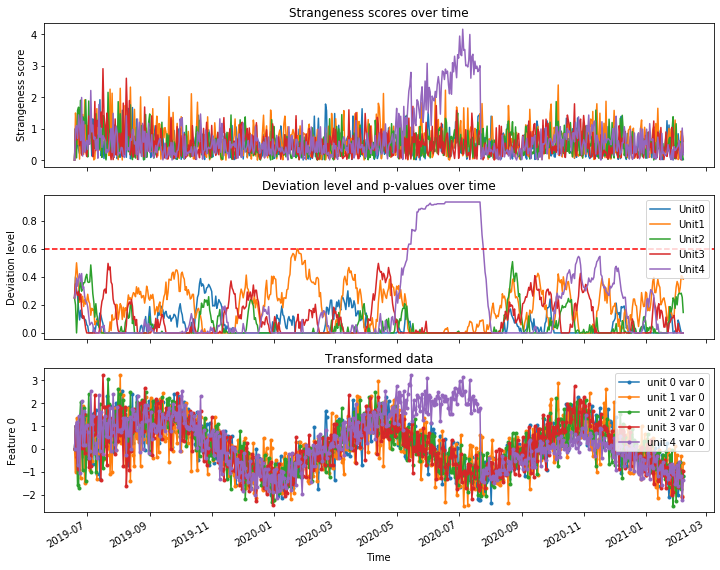

In [10]:
model = GroupAnomaly(nb_units, ids_target_units, transformer = "mean_std_normalize")

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    
    for uid, info in enumerate(infos):
        print("Unit: {} - Time: {} ==> strangeness: {}, deviation: {}"
              .format(uid, dt, info.strangeness, info.deviation), end="\r", flush=True)

model.plot_deviations(figsize=(12, 10))

However, the problem with such normalization (`transformer = "mean_std_normalize"`) is that it can be highly sensitive to outliers and anomalies in the data. To show this, consider the following example where we add few outliers to one of the systems (e.g. "Unit 3"). After running the code, you will notice that the transformed data of "Unit 3" will look different from the others, which leads to the detection of irrelevent anomalies all the time.

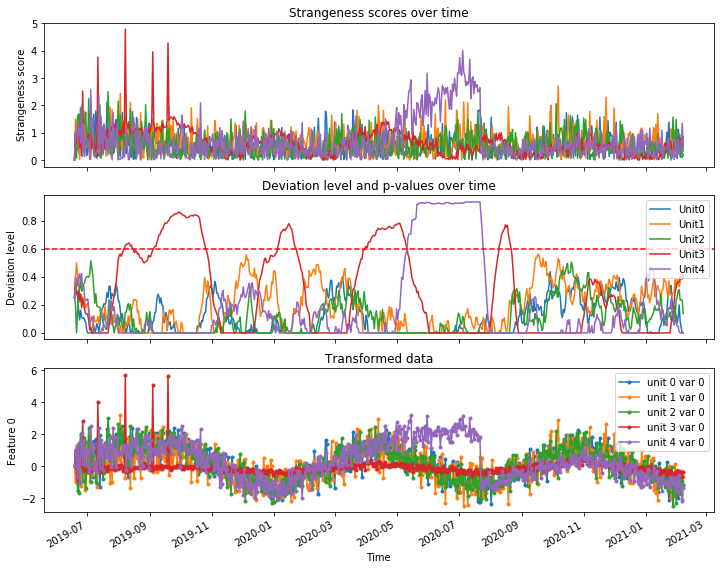

In [11]:
# Adding few outliers to the data-stream of Unit 3
ids = np.random.randint(0, 100, size = 5)
df = dataset.dfs[3]
df.iloc[ids] = df.values[ids] * 15

model = GroupAnomaly(nb_units, ids_target_units, transformer = "mean_std_normalize")

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    print(dt, end="\r", flush=True)

model.plot_deviations(figsize=(12, 10))

Instead of normalization, another way to make the different systems more comparable is to transform the data from each system based on how (and how much) it changes over time. For example, one may compute an estimation of the slope to see how a particular feature is changing over time.

However, in real-world, although the different systems may be subject to the same external conditions, their data may have different scales. In the following code example, all values of Unit 2 are multiplied by 2. You can see that if the data from each system is transformed based on measures of change such as the derivative or estimated slope, then Unit 2 would be deviating most of the time.

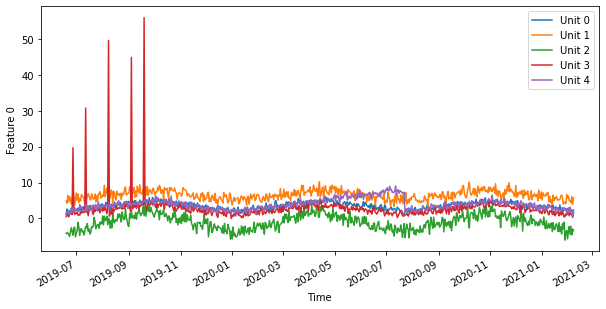

In [12]:
dataset.dfs[2][:] *= 2   # double the values from Unit 2

dataset.plot( figsize=(10, 5) )

One way to overcome these problems is to set the parameter `transformer` to `"pvalue"` or to `"mean_pvalue"` to characterize how each system changes based on its own historical data.

If we set `transformer = "pvalue"`, then each value $v_t$ from the time-series is transformed to a value $r_t$ which indicates the ranking of $v_t$ among the historical values from the same system:
$$
r_t = \frac{\#\{i = 1 \dots t-1 \mid v_i < v_t\}}{t-1} \in [0, 1]
$$

This is shown in the following code. After running the code, you will notice that Unit 2 is not affected by the different scale, and Unit 3 is not affected by the outliers. The transformed data of all systems looks similar (besides Unit 4 which clearly deviates during some time period).

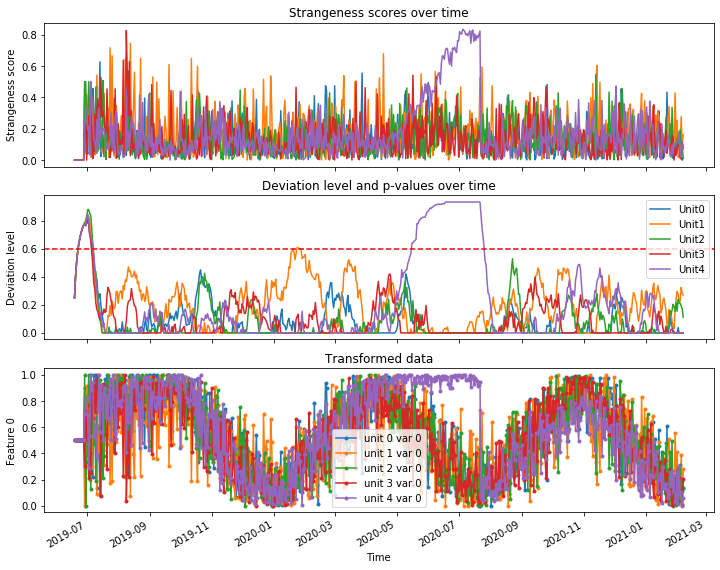

In [13]:
model = GroupAnomaly(nb_units, ids_target_units, transformer = "pvalue")

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    print(dt, end="\r", flush=True)

model.plot_deviations(figsize=(12, 10))

If we set `transformer = "mean_pvalue"`, then each value $v_t$ from the time-series is transformed to a value $\bar{r}_t$. This value consists of the average of the last $w$ values $\{r_{t-w}, ... r_t\}$, where $w$ refers to the parameter `w_transform` of the `GroupAnomaly` class.

After running the following code, you will notice that the transformed time-series is much more smooth, and it makes sense to only compute the strangeness scores (i.e. non-conformity) without the deviation level.

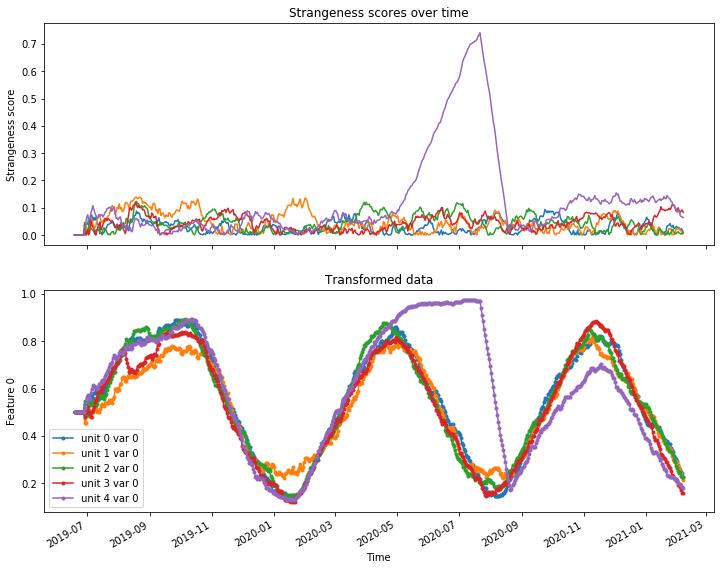

In [14]:
model = GroupAnomaly(nb_units, ids_target_units, transformer = "mean_pvalue")

for dt, x_units in dataset.stream():
    infos = model.predict(dt, x_units)
    print(dt, end="\r", flush=True)

model.plot_deviations(figsize=(12, 10))